# Configuration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import itertools

In [3]:
def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/CV_lab4/"

# Load and prepare data

In [5]:
transform = torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                   ])

In [6]:
image_datasets = {x: torchvision.datasets.MNIST(
    root=folder_path + "TrainingData",
    train=x == 'train',
    download=True,
    transform=transform
) for x in ['train', 'val']}

In [7]:
def create_dataloaders(batch_size=64):
    return {x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=True
    ) for x in ['train', 'val']}

In [8]:
dataloaders = create_dataloaders()

In [9]:
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
dataset_sizes

{'train': 60000, 'val': 10000}

In [10]:
class_names = dataloaders['train'].dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# Visualize data

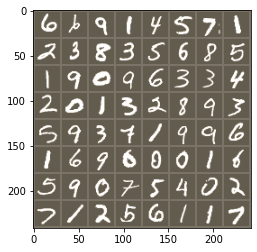

In [99]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Declare training functions

In [12]:
def train_model(model, criterion, optimizer, dataloaders_dict, num_epochs=10):
    y_loss = {phase: [] for phase in dataloaders_dict.keys()}
    y_acc = {phase: [] for phase in dataloaders_dict.keys()}

    best_acc = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in dataloaders_dict.keys():
                if 'train' in phase:
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)                       
                    labels_to_use = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled('train' in phase):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels_to_use)

                        if 'train' in phase:
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels_to_use)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                y_loss[phase].append(epoch_loss)
                y_acc[phase].append(epoch_acc.cpu().numpy())

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                  
    model.load_state_dict(best_model_wts)
    return model, y_loss, y_acc

In [13]:
def draw_graphs(y_loss, y_acc, phases, num_epochs=10):
    fig = plt.figure()
    ax0 = fig.add_subplot(121, title="loss")
    ax1 = fig.add_subplot(122, title="acc")
    x_epochs = [i + 1 for i in range(num_epochs)]

    for phase in phases:
        ax0.plot(x_epochs, y_loss[phase], label=phase)
        ax1.plot(x_epochs, y_acc[phase], label=phase)
    
    ax0.legend()
    ax1.legend()

    plt.show()

# Simple CNN

Тут визначено просту ахітектуру згорткової мережі, яка буде модфіковуватись далі із використанням модулів написаних власноруч.

In [14]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train Simple Net

In [15]:
simpleNet = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simpleNet.parameters(), lr=0.01, momentum=0.9)

In [16]:
simpleNet, simple_loss, simple_acc = train_model(simpleNet, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.2321 Acc: 0.9293
val Loss: 0.0533 Acc: 0.9835
Epoch 2/5
----------
train Loss: 0.0623 Acc: 0.9805
val Loss: 0.0452 Acc: 0.9852
Epoch 3/5
----------
train Loss: 0.0460 Acc: 0.9853
val Loss: 0.0349 Acc: 0.9889
Epoch 4/5
----------
train Loss: 0.0364 Acc: 0.9880
val Loss: 0.0379 Acc: 0.9886
Epoch 5/5
----------
train Loss: 0.0308 Acc: 0.9901
val Loss: 0.0303 Acc: 0.9891


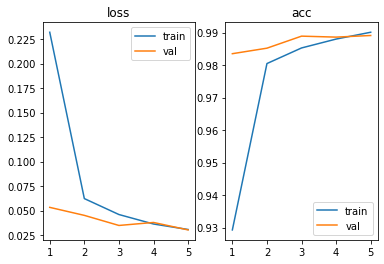

In [17]:
draw_graphs(simple_loss, simple_acc, simple_loss.keys(), num_epochs=5)

# CNN with dropout 

У цьому пункті наведено реаліхацію шару Dropout(виключення). Принцип його роботи доволі простий: під час forward propagation нашої мережі виключитати нейрони із заданою ймовірністю P. Таке виключення може бути застосоване як для вхідного шару, так і для прихованих. Приклад: вхід {1, 2, 3, 4, 5} перетворився на {1, 0, 3, 4, 5} після застосування Dropout. Основна ціль використання такого шару це боротьбта із перенавчанням. Використання таких шарів зазвичай призводить до трохи меншої точності моделі, але до значно кращого її узагальнення.

In [31]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float=0.5):
        super(MyDropout, self).__init__()
        self.p = p
        if self.p < 0 or self.p > 1:
            raise ValueError("p must be a probability")
            
    def forward(self, x):
        if self.training:
            x = x.mul(torch.empty(x.size()).uniform_(0, 1) >= self.p)
        return x

In [32]:
class DropoutNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = MyDropout()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train Dropout Net

In [33]:
dropoutNet = DropoutNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dropoutNet.parameters(), lr=0.01, momentum=0.9)

In [34]:
dropoutNet, drop_loss, drop_acc = train_model(dropoutNet, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.2903 Acc: 0.9058
val Loss: 0.0652 Acc: 0.9791
Epoch 2/5
----------
train Loss: 0.0834 Acc: 0.9742
val Loss: 0.0550 Acc: 0.9826
Epoch 3/5
----------
train Loss: 0.0616 Acc: 0.9812
val Loss: 0.0494 Acc: 0.9842
Epoch 4/5
----------
train Loss: 0.0503 Acc: 0.9841
val Loss: 0.0351 Acc: 0.9887
Epoch 5/5
----------
train Loss: 0.0429 Acc: 0.9860
val Loss: 0.0316 Acc: 0.9904


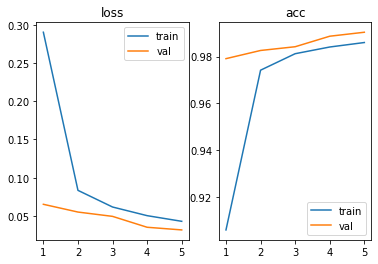

In [35]:
draw_graphs(drop_loss, drop_acc, drop_loss.keys(), num_epochs=5)

# CNN with Spatial Transformation

Spatial Transformation Networks (STN) дозволяють нейронній мережі навчитися виконувати просторові перетворення на вхідному зображенні, щоб підвищити геометричну інваріантність моделі. До прикладу, такі перетворення можуть обрізати зону "інтересу" із зображення. Тобто такі мережі або шари використовують для модифікації вхідного шару перед основною моделлю. Плюсом таких мереж є простота саме такої інтеграції у вже реалізовані архітектури. Час навчання моделі збільшується, але модель тренується на більше "важливих" даних, що призводить до збільшення точності.

Результат такої трансформації наведено після тренування моделі.

In [90]:
class MySpationTransformer(nn.Module):
    def __init__(self):
        super(MySpationTransformer, self).__init__()
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [91]:
class SpatialTransformerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stn = MySpationTransformer()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train Spatial transforamtion Net

In [92]:
spatialTransformerNet = SpatialTransformerNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(spatialTransformerNet.parameters(), lr=0.01, momentum=0.9)

In [93]:
spatialTransformerNet, spat_loss, spat_acc = train_model(spatialTransformerNet, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 1/5
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


train Loss: 0.2492 Acc: 0.9230
val Loss: 0.0926 Acc: 0.9702
Epoch 2/5
----------
train Loss: 0.0791 Acc: 0.9758
val Loss: 0.0434 Acc: 0.9855
Epoch 3/5
----------
train Loss: 0.0692 Acc: 0.9780
val Loss: 0.0488 Acc: 0.9839
Epoch 4/5
----------
train Loss: 0.0524 Acc: 0.9836
val Loss: 0.0478 Acc: 0.9848
Epoch 5/5
----------
train Loss: 0.0528 Acc: 0.9836
val Loss: 0.0506 Acc: 0.9844


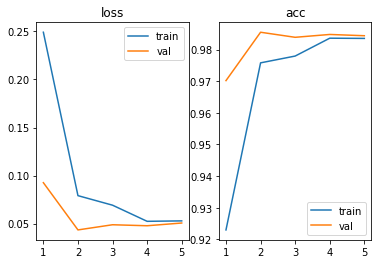

In [94]:
draw_graphs(spat_loss, spat_acc, spat_loss.keys(), num_epochs=5)

## Visualize Transformed images

In [97]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


inputs, classes = next(iter(dataloaders['train']))
transformed_input_tensor = spatialTransformerNet.stn(inputs)
in_data = convert_image_np(torchvision.utils.make_grid(inputs))
out_data = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


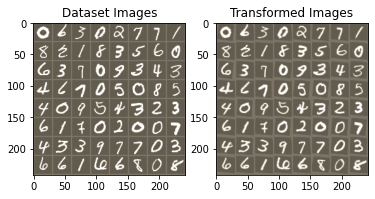

In [98]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(in_data)
ax[0].set_title('Dataset Images')

ax[1].imshow(out_data)
ax[1].set_title('Transformed Images')

plt.ioff()
plt.show()

# Depthwise Separable Convolutions using Pointwise convolution

Ідея Depthwise Separable Convolutions полягає в тому, щоб відокремити просторові (висота та ширина) дії та дії по каналам. Для досягання такого ефекту ми спочатку використвоємо згортку, яка є незалежною від каналів, а потім застосовуємо поточкову згортку(pointwise convolution).

Такий підхід дає змогу суттєво зменшити кількість параметрів у прихованих згорткових шарах нейронної мережі, що суттєво зменшує час тренування. Блоки Depthwise Separable Convolution можна використовувати замість звичайних згорткових шарів.

In [44]:
class PointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        depth_conv = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, groups=10)
        point_conv = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=1)
        self.depthwise_separable_conv = torch.nn.Sequential(depth_conv, point_conv)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.depthwise_separable_conv(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [45]:
pointNet = PointNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pointNet.parameters(), lr=0.01, momentum=0.9)

## Train Pointwise model

In [46]:
pointNet, point_loss, point_acc = train_model(pointNet, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.3430 Acc: 0.8921
val Loss: 0.0795 Acc: 0.9750
Epoch 2/5
----------
train Loss: 0.0812 Acc: 0.9750
val Loss: 0.0623 Acc: 0.9809
Epoch 3/5
----------
train Loss: 0.0598 Acc: 0.9811
val Loss: 0.0539 Acc: 0.9818
Epoch 4/5
----------
train Loss: 0.0475 Acc: 0.9849
val Loss: 0.0577 Acc: 0.9816
Epoch 5/5
----------
train Loss: 0.0431 Acc: 0.9865
val Loss: 0.0383 Acc: 0.9883


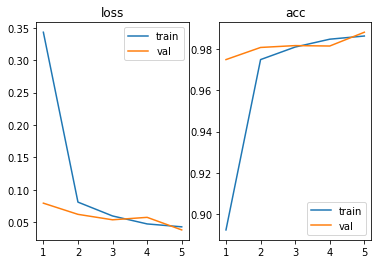

In [47]:
draw_graphs(point_loss, point_acc, point_loss.keys(), num_epochs=5)

Контрольнi запитання
1. Якi iснують блоки моделей для обробки зображень? Яке призначення,
архiтектура та принцип роботи (описати для декiлькох з блокiв)?
Принцип роботи обраних блоків описано вище.

2. У якi мiсця архiтектури згорткової нейронної мережi потрiбно дода-
вати обранi блоки, щоб покращити результати точностi?
Принцип роботи обраних блоків описано вище.

3. Як доданi блоки впливають на час навчання, точнiсть моделей?
Принцип роботи обраних блоків описано вище.

4. Чи залежить використання того чи iншого блока вiд вирiшуваної за-
дачi (класифiкацiя, регресiя, сегментацiя та iнше)? Чому?
Так, залежить. Очевидно, що блоки, які були розроблені спеціально для використання у згорткових мережах не підійдуть для задач регресії.